In [17]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import copy
from random import seed
from random import random
seed(1)

In [18]:
class normalizedDLT:
    
    def __init__(self):
        pass
    
    def similarityTransform(self, X):
        
        x = X[:,0]
        y = X[:,1]
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        num = np.sqrt(2)
        den = 0
        count = len(X)
        
        for i,j in zip(x,y):
            den = den + np.sqrt((i-x_mean)**2) + np.sqrt((j-y_mean)**2)
        
        den = den / count
        s = num / den
        tx = -s * x_mean
        ty = -s * y_mean
        
        T = np.array([[s, 0, tx ], 
                     [0, s, ty ], 
                     [0, 0, 1]])
        return T
    
    def normalize(self, X, T):
        
        normalized_image = []
        for [i,j] in X:
            normalized_image.append(T.dot(np.array([i,j,1])))
        
        normalized_image = np.array(normalized_image)
        return normalized_image
            
    def computeA(self, X1, X2):
        
        A = []
        for i , j in zip(X1, X2):
            x1, y1 = i[0], i[1]
            x2, y2 = j[0], j[1]
            A.append([0 ,0 ,0 , -x1, -y1, -1, y2 * x1, y2 * y1, y2])
            A.append([x1 ,y1 ,1 , 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        
        A = np.array(A)
        return A

    def findHomography(self, X1, X2):
        
        assert(X1.shape == X2.shape)
            
        T1 = self.similarityTransform(X1)
        T2 = self.similarityTransform(X2)
        
        X1 = self.normalize(X1, T1)
        X2 = self.normalize(X2, T2)
        A = self.computeA(X1, X2)
        
        u, s, vh = np.linalg.svd(A)
        v_12 = vh[-1]
        H = v_12.reshape((3,3))
        T2_inv = np.linalg.inv(T2)
        H = T2_inv.dot(H.dot(T1))
        h_33 = H[2,2]
        H = H / h_33
        return H
    

In [41]:
def drawCircles(img, center_coordinates, radius = 20, thickness = -2):
    
    no_of_points = len(center_coordinates)
    temp_img = copy.deepcopy(img)
    
    for i in range(no_of_points):
        [px, py] = center_coordinates[i]
        color = tuple(np.random.randint(0,255,3).tolist())
        temp_img = cv2.circle(temp_img, (px, py), radius, color, thickness)
    
    return temp_img

In [57]:
def drawLines(img, start_points, end_points,shift, thickness = 10):
    assert(start_points.shape == end_points.shape)
    
    temp_img = copy.deepcopy(img)
    
    for [sx,sy], [ex, ey] in zip(start_points, end_points):
        color = tuple(np.random.randint(0,255,3).tolist())
        temp_img = cv2.arrowedLine(temp_img,(sx, sy), (ex + shift, ey),color, thickness)
    
    return temp_img

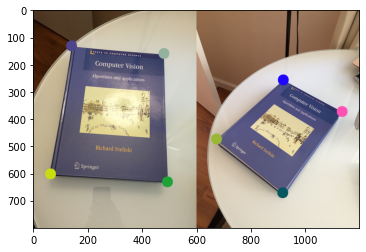

In [58]:
image1 = cv2.imread("./Input Images/book2.jpg", cv2.IMREAD_UNCHANGED)
image2 = cv2.imread("./Input Images/book1.jpg", cv2.IMREAD_UNCHANGED)

pts_src = np.array([[141, 131], [480, 159], [493, 630],[64, 601]])
pts_dst = np.array([[318, 256],[534, 372],[316, 670],[73, 473]])

height1, width1 = image1.shape[:2]
height2, width2 = image2.shape[:2]

image1 = drawCircles(image1, pts_src)
image2 = drawCircles(image2, pts_dst)
combined_image12 = np.hstack((image1, image2))

plt.figure()
plt.imshow(cv2.cvtColor(combined_image12, cv2.COLOR_BGR2RGB))
cv2.imwrite('./Output Images/combined_image12.jpg', combined_image12)
plt.show()

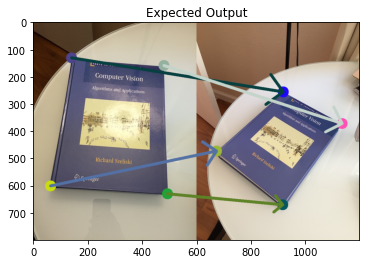

In [59]:
combined_image12_with_keypoints = np.hstack((image1, image2))
combined_image12_with_keypoints_lines = drawLines(combined_image12_with_keypoints, pts_src, pts_dst, width1)
plt.figure()
plt.title("Expected Output")
plt.imshow(cv2.cvtColor(combined_image12_with_keypoints_lines, cv2.COLOR_BGR2RGB))
cv2.imwrite('./Output Images/combined_image12_with_keypoints_lines.jpg',combined_image12_with_keypoints_lines)
plt.show()

In [60]:
ndlt = normalizedDLT()

H = ndlt.findHomography(pts_src,pts_dst)
h = cv2.findHomography(pts_src, pts_dst)[0]

im_out1 = cv2.warpPerspective(image1, H, (image2.shape[1],image2.shape[0]))
im_out2 = cv2.warpPerspective(image1, h, (image2.shape[1],image2.shape[0]))

print("*****************Homography matrix calculated by handcrafted function*****************")
print(H)
print("*****************Homography matrix calculated by OpenCV inbulit function*****************")
print(h)

*****************Homography matrix calculated by handcrafted function*****************
[[ 4.34043935e-01 -4.19622184e-01  2.91709494e+02]
 [ 1.46491654e-01  4.41418278e-01  1.61369294e+02]
 [-3.62463336e-04 -9.14274844e-05  1.00000000e+00]]
*****************Homography matrix calculated by OpenCV inbulit function*****************
[[ 4.34043935e-01 -4.19622184e-01  2.91709494e+02]
 [ 1.46491654e-01  4.41418278e-01  1.61369294e+02]
 [-3.62463336e-04 -9.14274844e-05  1.00000000e+00]]


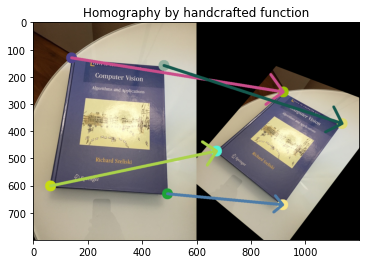

In [61]:
im_out1 = drawCircles(im_out1, pts_dst)
im_out2 = drawCircles(im_out2, pts_dst)

plt.figure()
plt.title("Homography by handcrafted function")
im_out1 = np.hstack((image1, im_out1))
im_out1 = drawLines(im_out1, pts_src, pts_dst, width1)
plt.imshow(cv2.cvtColor(im_out1, cv2.COLOR_BGR2RGB))
cv2.imwrite('./Output Images/im_out1.jpg',im_out1)
plt.show()

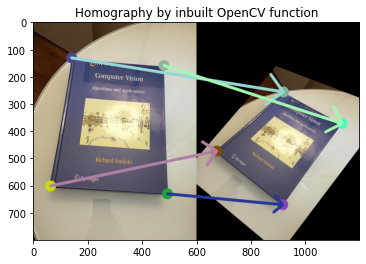

In [62]:
plt.figure()
plt.title("Homography by inbuilt OpenCV function")
im_out2 = copy.deepcopy(np.hstack((image1, im_out2)))
im_out2 = drawLines(im_out2, pts_src, pts_dst, width1)
plt.imshow(cv2.cvtColor(im_out2, cv2.COLOR_BGR2RGB))
cv2.imwrite('./Output Images/im_out2.jpg',im_out2)
plt.show()

In [72]:
# Read and Process the .txt file
images = dict() 
with open(os.getcwd()+'/keypoints_boat.txt') as filehandle:
    filecontents = filehandle.readlines()
    i = 0
    for line in filecontents:
        current = (line.split(" = ")[1]).replace("; ",",").replace(" ","")
        j = 1
        image = list()
        while j < len(current) and j+3 < len(current):
            image.append(int(current[j:j+3]))
            j = j + 4
        images[i] = np.array(image).reshape((25,2))   
        i = i + 1  

pts_src_boat, pts_dst_boat = images[0], images[1]

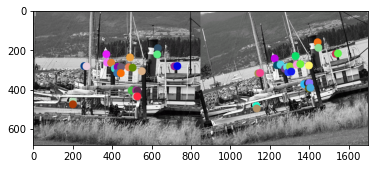

In [73]:
boat1 = cv2.imread("./Input Images/img1+points.png", cv2.IMREAD_UNCHANGED)
boat2 = cv2.imread("./Input Images/img2+points.png", cv2.IMREAD_UNCHANGED)

boat1 = drawCircles(boat1, pts_src_boat)
boat2 = drawCircles(boat2, pts_dst_boat)

combined_boatimage12 = np.hstack((boat1, boat2))

plt.figure()
plt.imshow(combined_boatimage12 )
cv2.imwrite('./Output Images/combined_boatimage12.jpg', combined_boatimage12)
plt.show()

In [78]:
H_boat = ndlt.findHomography(pts_src_boat,pts_dst_boat)
im_out_boat1 = cv2.warpPerspective(boat1, H_boat, (boat2.shape[1],boat2.shape[0]))

h_boat = cv2.findHomography(pts_src_boat,pts_dst_boat)[0]
im_out_boat2 = cv2.warpPerspective(boat1, h_boat, (boat2.shape[1],boat2.shape[0]))

height3, width3 = boat1.shape[:2]
height4, width4 = boat2.shape[:2]

print("*****************Homography matrix calculated by handcrafted function*****************")
print(H_boat)
print("*****************Homography matrix calculated by OpenCV inbulit function*****************")
print(h_boat)

*****************Homography matrix calculated by handcrafted function*****************
[[ 8.75450150e-01  2.32381631e-01  3.47041343e+00]
 [-2.14134757e-01  8.79255196e-01  1.29608489e+02]
 [ 1.10829846e-05  3.04020213e-05  1.00000000e+00]]
*****************Homography matrix calculated by OpenCV inbulit function*****************
[[ 8.75621247e-01  2.32487163e-01  3.42174343e+00]
 [-2.14118735e-01  8.79376769e-01  1.29602218e+02]
 [ 1.12366054e-05  3.05886234e-05  1.00000000e+00]]


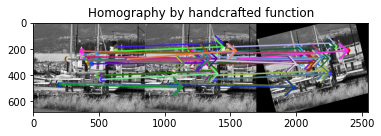

In [77]:
plt.figure()
plt.title("Homography by handcrafted function")
im_out_boat1  = copy.deepcopy(np.hstack((boat1, im_out_boat1)))
im_out_boat1  = drawLines(im_out_boat1, pts_src_boat, pts_dst_boat, width3)
plt.imshow(cv2.cvtColor(im_out_boat1, cv2.COLOR_BGR2RGB))
cv2.imwrite('./Output Images/im_out_boat1.jpg',im_out_boat1)
plt.show()

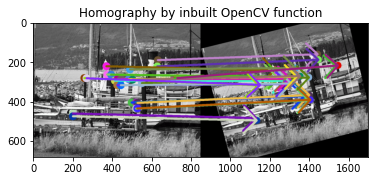

In [76]:
plt.figure()
plt.title("Homography by inbuilt OpenCV function")
im_out_boat2  = copy.deepcopy(np.hstack((boat1, im_out_boat2)))
im_out_boat2  = drawLines(im_out_boat2, pts_src_boat, pts_dst_boat, width3)
plt.imshow(cv2.cvtColor(im_out_boat2, cv2.COLOR_BGR2RGB))
cv2.imwrite('./Output Images/im_out_boat2.jpg',im_out_boat2)
plt.show()

# <font color='red'>    🤩 Improvements and Suggestions are appreciated   🤩</font>